In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

基于位置的前馈网络（Position-wise Feed-Forward Network, FFN）是Transformer模型中的一个关键组件。它对序列中的每个位置独立地应用相同的前馈神经网络，从而实现对每个位置的特征进行变换。这种处理方式使得前馈网络能够对每个位置进行独立变换，而不依赖于其他位置的特征。这与卷积神经网络（CNN）和循环神经网络（RNN）有所不同，后者通常会考虑输入数据的局部或全局信息。

### 基于位置的前馈网络（FFN）结构

基于位置的前馈网络通常由两层全连接层（或线性层）组成，中间使用激活函数进行非线性变换。在Transformer中，每个位置的特征向量都通过相同的前馈网络进行变换。

具体来说，FFN的步骤如下：

1. **输入线性变换**：首先对输入进行线性变换，将输入特征维度从`ffn_num_input`变换为隐藏层维度`ffn_num_hiddens`。
2. **激活函数**：然后通过ReLU激活函数引入非线性。
3. **输出线性变换**：最后再进行一次线性变换，将隐藏层的输出变换为最终的输出特征维度`ffn_num_outputs`。

基于位置的前馈网络

In [2]:
class PositionWiseFFN(nn.Module):
    '''
    基于位置的前馈网络
    初始化方法接收输入特征维度`ffn_num_input`，
    隐藏层特征维度`ffn_num_hiddens`和输出特征维度`ffn_num_outputs`。
    '''
    def __init__(
        self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs
    ):
        super(PositionWiseFFN, self).__init__(**kwargs)
        '''
        第一层线性变换，将输入特征维度变换为隐藏层特征维度。
        '''
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        '''
        使用ReLU激活函数引入非线性。
        '''
        self.relu = nn.ReLU()
        '''
        第二层线性变换，将隐藏层特征维度变换为输出特征维度。
        '''
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    def forward(self, X):
        '''
        在前向传播中，首先通过第一层线性变换，
        然后通过ReLU激活函数，最后通过第二层线性变换。
        '''
        return self.dense2(
            self.relu(
                self.dense1(X)
            )
        )

In [3]:
'''
创建了一个基于位置的前馈网络`ffn`，输入的张量形状为`(2, 3, 4)`，
表示批量大小为2，序列长度为3，特征维度为4。
前馈网络会将输入变换为形状为`(2, 3, 8)`的输出。
'''
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(
    torch.ones(
        (2, 3, 4)
    )
)[0]

tensor([[ 0.5234, -0.1565,  0.6883, -0.3492, -0.3914, -0.6978, -0.6405,  0.0026],
        [ 0.5234, -0.1565,  0.6883, -0.3492, -0.3914, -0.6978, -0.6405,  0.0026],
        [ 0.5234, -0.1565,  0.6883, -0.3492, -0.3914, -0.6978, -0.6405,  0.0026]],
       grad_fn=<SelectBackward0>)


通过这种方式，基于位置的前馈网络可以在保持每个位置的独立性的同时对特征进行非线性变换，使得模型能够更好地捕捉复杂的特征关系。


---
残差连接和层规范化

在Transformer中，残差连接和层规范化是构建有效深度架构的关键组件。它们在每个子层中起到至关重要的作用，以确保信息的稳定传递和训练的有效性。

残差连接

残差连接最初是在ResNet中提出的，目的是解决深度神经网络训练中的梯度消失和梯度爆炸问题。在残差连接中，输入直接跳过一个或多个层，并与这些层的输出相加。这种连接方式允许梯度在反向传播时直接传回输入层，从而缓解了梯度消失的问题。

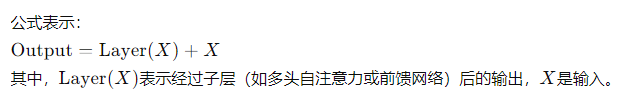

层规范化

层规范化（Layer Normalization）和批量规范化（Batch Normalization）都是用于加速训练和提高模型稳定性的技术。与批量规范化不同，层规范化是基于特征维度进行规范化的，这使得它在自然语言处理任务中效果更好，因为输入通常是变长序列。

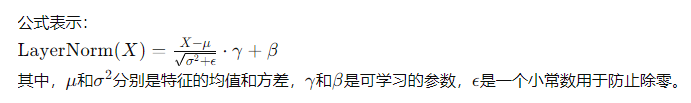



In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor(
    [
        [1, 2], [2, 3]
    ], dtype=torch.float32
)

print("layer norm:", ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):
    """
    残差连接后进行层规范化
    """
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        '''
        定义dropout层
        '''
        self.dropout = nn.Dropout(dropout)
        '''
        定义层规范化
        '''
        self.ln = nn.LayerNorm(normalized_shape)
    def forward(self, X, Y):
        '''
        残差连接后进行层规范化
        '''
        return self.ln(self.dropout(Y) + X)

In [6]:
add_norm = AddNorm([3,4], 0.5)
add_norm.eval()
add_norm(
    torch.ones((2, 3, 4)),
    torch.ones((2, 3, 4))
).shape

torch.Size([2, 3, 4])

通过这种方式，残差连接和层规范化能够在保持信息流动和稳定训练的同时，使模型更深层次的特征表达成为可能。

Transformer编码器

在这一部分，将实现Transformer的编码器部分。编码器由多个相同的编码器层（`EncoderBlock`）堆叠而成。每个编码器层包含两个主要子层：多头自注意力（Multi-Head Self-Attention）和基于位置的前馈网络（Position-Wise Feed-Forward Network）。这两个子层都使用了残差连接和层规范化。


In [7]:
'''
`EncoderBlock`类实现了Transformer编码器的一个层。
它包含两个主要子层：
    多头自注意力和基于位置的前馈网络，
    这两个子层都使用了残差连接和层规范化。
'''
class EncoderBlock(nn.Module):
    '''
    Transformer 编码器
    '''
    def __init__(
        self, 
        key_size, 
        query_size, 
        value_size, 
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens, 
        num_heads,
        dropout,
        use_bias=False,
        **kwargs
    ):
        super(EncoderBlock, self).__init__(**kwargs)
        '''
        - `self.attention`：多头自注意力层。用于在输入序列的不同位置之间计算相关性。
        '''
        self.attention = d2l.MultiHeadAttention(
            key_size, 
            query_size, 
            value_size, 
            num_hiddens,
            num_heads, 
            dropout,
            use_bias
        )
        '''
        - `self.addnorm1`：第一个残差连接和层规范化模块，包含多头自注意力层的输出和输入的残差连接。
        '''
        self.addnorm1 = AddNorm(norm_shape, dropout)
        '''
        - `self.ffn`：基于位置的前馈网络。对每个位置的表示进行变换。
        '''
        self.ffn = PositionWiseFFN(
            ffn_num_input, 
            ffn_num_hiddens,
            num_hiddens
        )
        '''
        - `self.addnorm2`：第二个残差连接和层规范化模块，包含前馈网络的输出和输入的残差连接。
        '''
        self.addnorm2 = AddNorm(norm_shape, dropout)
    def forward(self, X, valid_lens):
        '''
        1. 计算多头自注意力的输出，并通过残差连接和层规范化（`addnorm1`）。
        2. 计算前馈网络的输出，并通过残差连接和层规范化（`addnorm2`）。
        '''
        Y = self.addnorm1(
            X, self.attention(X, X, X, valid_lens)
        )
        return self.addnorm2(Y, self.ffn(Y))

In [8]:
'''
- 输入`X`的形状为`(2, 100, 24)`，
    表示批量大小为2，每个序列有100个时间步，每个时间步有24个特征。

- `valid_lens`表示有效长度。
- `EncoderBlock`实例化一个编码器块，并将输入`X`和`valid_lens`传入，
    得到输出`output`的形状为`(2, 100, 24)`，与输入形状相同。

'''
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(
    24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5 
)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [9]:
'''
TransformerEncoder类

`TransformerEncoder`类是整个Transformer编码器的实现，它由多个`EncoderBlock`实例堆叠而成。
'''
class TransformerEncoder(d2l.Encoder):
    '''
    Transformer编码器
    '''
    def __init__(
        self, 
        vocab_size, 
        key_size, 
        query_size, 
        value_size,
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens,
        num_heads,
        num_layers,
        dropout,
        use_bias=False,
        **kwargs
    ):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        '''
        - `self.embedding`：词嵌入层。将输入的词索引转换为词向量。
        '''
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        '''
        - `self.pos_encoding`：位置编码层。为每个词向量添加位置信息，以捕捉序列中的顺序信息。
        '''
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        '''
        - `self.blks`：一个包含多个`EncoderBlock`实例的顺序容器（`nn.Sequential`）。每个`EncoderBlock`都是一个Transformer编码器层。
        '''
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block"+str(i),
                EncoderBlock(
                    key_size,
                    query_size,
                    value_size,
                    num_hiddens,
                    norm_shape, 
                    ffn_num_input,
                    ffn_num_hiddens,
                    num_heads,
                    dropout,
                    use_bias
                )
            )
    def forward(self, X, valid_lens, *args):
        '''
        因为位置编码值在-1和1之间，
        因此嵌入值乘以嵌入维度的平方根进行缩放，
        然后再与位置编码相加。

        1. 输入`X`经过词嵌入层得到词向量。
        2. 将词向量乘以嵌入维度的平方根进行缩放，然后加上位置编码。
        '''
        X = self.pos_encoding(
            self.embedding(X) * math.sqrt(self.num_hiddens)
        )
        self.attention_weights = [None] * len(self.blks)
        '''
        3. 依次通过每个编码器层`blk`，得到最终的编码器输出。
        '''
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X
        

In [10]:

encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5
)
encoder.eval()
encoder(
    torch.ones(
        (2, 100),
        dtype=torch.long
    ),
    valid_lens
).shape

torch.Size([2, 100, 24])

- `EncoderBlock`类实现了Transformer编码器的一个层，包括多头自注意力和基于位置的前馈网络。
- `TransformerEncoder`类堆叠了多个`EncoderBlock`实例，实现了整个Transformer编码器。
- 在实际应用中，Transformer编码器可以处理各种序列数据，如文本、图像和语音等。


---
解码器

在Transformer模型中，解码器用于生成输出序列。与编码器类似，解码器也是由多个相同的层组成，每层包含三个子层：解码器自注意力、多头“编码器-解码器”注意力、和基于位置的前馈网络。每个子层都使用残差连接和紧随的层规范化。

In [11]:
'''

`DecoderBlock`类实现了Transformer解码器的一个层。它包含三个主要子层：

- 解码器自注意力（Masked Multi-Head Self-Attention）
- 多头“编码器-解码器”注意力（Multi-Head Encoder-Decoder Attention）
- 基于位置的前馈网络（Position-Wise Feed-Forward Network）

这些子层都使用了残差连接和层规范化。
'''
class DecoderBlock(nn.Module):
    '''
    解码器中1个块
    '''
    def __init__(
        self, 
        key_size, 
        query_size, 
        value_size, 
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens,
        num_heads,
        dropout,
        i,
        **kwargs,
    ):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        '''
        - `self.attention1`：
            掩蔽多头自注意力层，确保查询位置只会与之前生成的词元位置进行注意力计算。
        - `self.addnorm1`：
            残差连接和层规范化模块，包含多头自注意力层的输出和输入的残差连接。
        - `self.attention2`：
            多头“编码器-解码器”注意力层，查询来自解码器的输出，键和值来自编码器的输出。
        - `self.addnorm2`：
            残差连接和层规范化模块，包含多头“编码器-解码器”注意力层的输出和输入的残差连接。
        - `self.ffn`：
            基于位置的前馈网络，对每个位置的表示进行变换。
        - `self.addnorm3`：
            残差连接和层规范化模块，包含前馈网络的输出和输入的残差连接。

        '''
        self.attention1 = d2l.MultiHeadAttention(
            key_size, 
            query_size, 
            value_size, 
            num_hiddens,
            num_heads,
            dropout,
        )
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, 
            query_size, 
            value_size, 
            num_hiddens,
            num_heads,
            dropout,
        )
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input,
            ffn_num_hiddens,
            num_hiddens
        )
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        '''
        1. 处理解码器的输入，考虑训练和预测阶段的不同处理方式。
        2. 计算掩蔽多头自注意力的输出，并通过残差连接和层规范化（`addnorm1`）。
        3. 计算多头“编码器-解码器”注意力的输出，并通过残差连接和层规范化（`addnorm2`）。
        4. 计算前馈网络的输出，并通过残差连接和层规范化（`addnorm3`）。
        '''
        
        '''
        从state中提取编码器的输出和有效长度。
        '''
        enc_outputs, enc_valid_lens = state[0], state[1]
        '''
        判断当前层的state是否为空。
        '''
        if state[2][self.i] is None:
            key_values = X
        else:
            '''
            将之前生成的词元和当前输入进行拼接，形成key_values。
            '''
            key_values = torch.cat(
                (
                    state[2][self.i], X
                ), axis = 1
            )
        '''
        更新当前层的state。
        '''
        state[2][self.i] = key_values
        '''
        在训练阶段，计算解码器的有效长度。
        '''
        if self.training:
            batch_size, num_steps, _ = X.shape
            '''
            生成解码器的有效长度。
            '''
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device
            ).repeat(batch_size, 1)
        else:
            dec_valid_lens = None
        '''
        自注意力

        计算掩蔽多头自注意力的输出。
        '''
        X2 = self.attention1(
            X, key_values, key_values, dec_valid_lens
        )
        '''
        通过残差连接和层规范化。
        '''
        Y = self.addnorm1(X, X2)
        '''
        计算多头“编码器-解码器”注意力的输出。
        '''
        Y2 = self.attention2(
            Y, enc_outputs, enc_outputs, enc_valid_lens
        )
        '''
        通过残差连接和层规范化。
        '''
        Z = self.addnorm2(Y, Y2)
        '''
        计算前馈网络的输出，并通过残差连接和层规范化，返回输出和state。
        '''
        return self.addnorm3(Z, self.ffn(Z)), state

In [12]:
decoder_blk = DecoderBlock(
    24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0
)
decoder_blk.eval()
'''
输入`X`的形状为`(2, 100, 24)`，表示批量大小为2，每个序列有100个时间步，每个时间步有24个特征。
'''
X = torch.ones((2, 100, 24))
'''
`state`包含编码器的输出、有效长度和解码器每一层的状态。
'''
state = [
    encoder_blk(X, valid_lens),
    valid_lens,
    [None]
]
'''
`DecoderBlock`实例化一个解码器块，并将输入`X`和`state`传入，
得到输出`output`的形状为`(2, 100, 24)`，与输入形状相同。
'''
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

- `DecoderBlock`类实现了Transformer解码器的一个层，包括掩蔽多头自注意力、多头“编码器-解码器”注意力和基于位置的前馈网络。
- `TransformerDecoder`类堆叠了多个`DecoderBlock`实例，实现了整个Transformer解码器。
- 在实际应用中，Transformer解码器可以用于各种序列生成任务，如机器翻译和文本生成等。

---
`TransformerDecoder`类是整个Transformer解码器的实现，它由多个`DecoderBlock`实例堆叠而成。最后，通过一个全连接层计算所有词汇表大小的可能输出词元的预测值。


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(
        self, 
        vocab_size,
        key_size, 
        query_size, 
        value_size, 
        num_hiddens,
        norm_shape,
        ffn_num_input,
        ffn_num_hiddens,
        num_heads,
        num_layers,
        dropout,
        **kwargs,
    ):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        '''
        词嵌入层，将输入的词索引转换为词向量。
        '''
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        '''
        位置编码层，为每个词向量添加位置信息。
        '''
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        '''
        一个包含多个`DecoderBlock`实例的顺序容器，每个`DecoderBlock`都是一个Transformer解码器层。
        '''
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                'block'+str(i),
                DecoderBlock(
                    key_size,
                    query_size,
                    value_size,
                    num_hiddens,
                    norm_shape,
                    ffn_num_input,
                    ffn_num_hiddens,
                    num_heads,
                    dropout,
                    i
                )
            )
        '''
        全连接层，将解码器输出转换为词汇表大小的预测分布。
        '''
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [
            enc_outputs, enc_valid_lens, [None] * self.num_layers
        ]
    def forward(self, X, state):
        '''
        1. 输入`X`经过词嵌入层得到词向量，并加上位置编码。
        2. 依次通过每个解码器层`blk`，得到最终的解码器输出。
        3. 将解码器输出通过全连接层，得到词汇表大小的预测分布。
        '''
        '''
        输入`X`经过词嵌入层得到词向量，并加上位置编码。
        '''
        X = self.pos_encoding(
            self.embedding(X) * math.sqrt(self.num_hiddens)
        )
        '''
        初始化解码器的注意力权重。
        '''
        self._attention_weigths = [
            [None] * len(self.blks) for _ in range (2)
        ]
        '''
        依次通过每个解码器层`blk`，得到最终的解码器输出。
        '''
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            '''
            存储解码器自注意力的权重。
            '''
            self._attention_weigths[0][i] = blk.attention1.attention.attention_weights
            '''
            存储多头“编码器-解码器”注意力的权重。
            '''
            self._attention_weigths[1][i] = blk.attention2.attention.attention_weights
        '''
        将解码器输出通过全连接层，得到词汇表大小的预测分布，并返回状态`state`。
        '''
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self.attention_weights

---
训练

In [14]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]


In [15]:
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(
    batch_size, num_steps
)

encoder = TransformerEncoder(
    len(src_vocab),
    key_size, 
    query_size, 
    value_size, 
    num_hiddens,
    norm_shape,
    ffn_num_input,
    ffn_num_hiddens,
    num_heads,
    num_layers,
    dropout
)
decoder = TransformerDecoder(
    len(tgt_vocab),
    key_size, 
    query_size, 
    value_size, 
    num_hiddens,
    norm_shape,
    ffn_num_input,
    ffn_num_hiddens,
    num_heads,
    num_layers,
    dropout
)

net = d2l.EncoderDecoder(encoder, decoder)

loss 0.030, 9373.9 tokens/sec on cuda:0


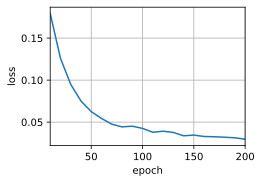

In [16]:
d2l.train_seq2seq(
    net, train_iter, lr, num_epochs, tgt_vocab, device
)

In [ ]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True
    )
    print(
        f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}'
         )